In [1]:
import segmenter, utils
import UNet_

import h5py
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyvoi
import pandas as pd
import seaborn as sns
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Set variables

In [3]:
# data_path = "/storage2/projects/smartEM/em-vis/smartem-data-test-errors.hdf5"
data_path = "/storage2/projects/smartEM/em-vis/smartem-data-error-em-test.hdf5"
device = torch.device("cuda:4")

model = UNet_.UNet(1,2)
model_path = '/storage2/projects/smartEM/errnet-data/unet_4_4.81e-01.pth'

In [4]:
model = model.to(device)
weights = torch.load(model_path, map_location=device)
model.load_state_dict(weights)
model.eval()
print()

# Compute VI vs dwell time

In [5]:
def get_prediction(im, model):
    # applies network to 2d numpy image
    im = im[np.newaxis, ...] # make 3d
    im = torch.as_tensor(im.copy()).float().contiguous()
    im = im.unsqueeze(0)
    im = im.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = model(im).cpu()
        # binarize the output based on the threshold of 0.5
        if (output >= 0).all() and (output <= 1).all():
            mask = output > 0.5
        else:
            output = torch.sigmoid(output)
            mask = output > 0.5

    mask = mask.squeeze().numpy()[1]
    mask = mask.astype(np.uint8) * 255
    probs = output.squeeze().numpy()[1]

    return mask, probs
    

In [6]:
data_dwts = []
data_hdt_vois = []
data_hdt_ious = []
data_gt_vois = []
data_gt_ious = []
predictions = []

with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), disable=True):
        group = f[reg]

        dwts = [int(dwt) for dwt in list(group.keys())]
        dwts.sort()
        slowest_dwt = dwts[-1]

        gt_mask = group[f"{slowest_dwt}/mask"][()]
        print(f"{np.sum(gt_mask)/np.amax(gt_mask)}/{np.prod(gt_mask.shape)} true rescan pixels")

        # 1200ns
        im = group[f"{slowest_dwt}/im"][()]
        hdt_mask, _ = get_prediction(im, model)


        # all dwts
        for dwt in group.keys():
            im = group[f"{dwt}/im"][()]

            mask, probs = get_prediction(im, model)
            print(f"{np.sum(mask)/np.amax(mask)}/{np.prod(mask.shape)} predicted rescan pixels")

            # iou_gt = utils.get_IoU(mask, gt_mask)
            print(np.unique(mask), np.unique(hdt_mask))
            iou_hdt = utils.get_IoU(mask, hdt_mask)

            # voi_gt,_,_ = pyvoi.VI(gt_mask.flatten(), mask.flatten())
            # voi_hdt,_,_ = pyvoi.VI(hdt_mask.flatten(), mask.flatten())
            # data_gt_vois.append(voi_gt.item())
            # data_hdt_vois.append(voi_hdt.item())

            # data_gt_ious.append(iou_gt)
            data_hdt_ious.append(iou_hdt)
            data_dwts.append(int(dwt))



# data = {"Dwell Time (ns)": data_dwts, "Variation of Information from GT (nats)": data_gt_vois, "Variation of Information from 1200ns (nats)": data_hdt_vois}
# df = pd.DataFrame(data=data)

29998.0/3133440 true rescan pixels
2.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
803246.0/3133440 true rescan pixels
34.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
1072761.0/3133440 true rescan pixels


/tmp/ipykernel_1697008/1490695309.py:29: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{np.sum(mask)/np.amax(mask)}/{np.prod(mask.shape)} predicted rescan pixels")
/home/ssawmya-local/FM_work/SmartEM/smartem/segmentation/utils.py:102: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(intersection) / np.sum(union)


nan/3148800 predicted rescan pixels
[0] [0]
910090.0/3133440 true rescan pixels
55.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
573447.0/3133440 true rescan pixels
3.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
1015523.0/3133440 true rescan pixels
17.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
1138836.0/3133440 true rescan pixels
6.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
1105231.0/3133440 true rescan pixels
nan/3148800 predicted rescan pixels
[0] [0]
1070484.0/3133440 true rescan pixels
23.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
873885.0/3133440 true rescan pixels
50.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
975675.0/3133440 true rescan pixels
1.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
564953.0/3133440 true rescan pixels
60.0/3148800 predicted rescan pixels
[  0 255] [  0 255]
1052352.0/3133440 true rescan pixels
nan/3148800 predicted rescan pixels
[0] [0]
965232.0/3133440 true rescan pixels
nan/3148800 pr

In [16]:
with h5py.File(data_path, "r") as f:
    for reg in tqdm(f.keys(), disable=True):
        group = f[reg]
        print(group.keys())

<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>
<KeysViewHDF5 ['50']>


<Axes: xlabel='Dwell Time (ns)', ylabel='IoU with 1200ns'>

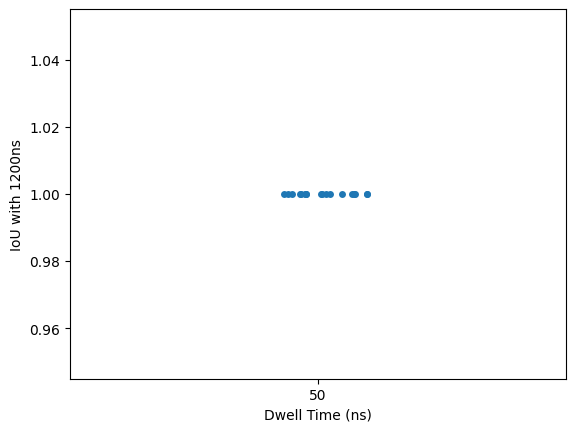

In [8]:
data = {"Dwell Time (ns)": data_dwts, "IoU with 1200ns": data_hdt_ious}
df = pd.DataFrame(data=data)
sns.stripplot(data=df, y="IoU with 1200ns", x="Dwell Time (ns)")

<Axes: xlabel='Dwell Time (ns)', ylabel='Variation of Information from GT (nats)'>

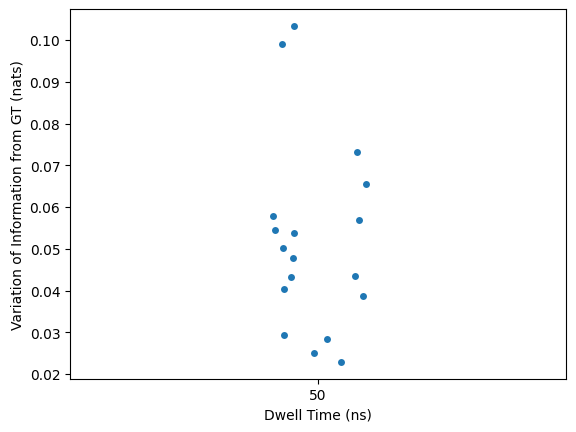

In [28]:
sns.stripplot(data=df, y="Variation of Information from GT (nats)", x="Dwell Time (ns)")

# Visualize result

In [15]:
images = {}

desired_dwts = [50] #[25, 50, 100, 400, 800, 1200]

with h5py.File(data_path, "r") as f:
    reg = list(f.keys())[2]
    group = f[reg]

    dwts = [int(dwt) for dwt in list(group.keys())]
    dwts.sort()
    slowest_dwt = dwts[-1]
    
    gt_mask = group[f"{slowest_dwt}/mask"][()]
    gt_mask_masked = np.ma.masked_where(gt_mask == 0, gt_mask)
    frac_rescan = np.sum(gt_mask > 0) / gt_mask.size

    for dwt in desired_dwts:
        im = group[f"{dwt}/im"][()]

        # make the first dimension divisible by 32
        # gt_mask = gt_mask[:gt_mask.shape[0]//32*32, :]

        mask, probs = get_prediction(im, model)

        mask_masked = np.ma.masked_where(mask == 0, mask)

        # print(mask.shape, gt_mask.shape)
        mask = mask[:gt_mask.shape[0], :gt_mask.shape[1]]

        iou = utils.get_IoU(mask, gt_mask)

        # voi,_,_ = pyvoi.VI(gt_mask.flatten(), mask.flatten())
        title_stem = f"{dwt}ns_IoU_{iou.item():.2f}"

        print(f"{probs.shape} {probs.dtype} {np.amin(probs)}-{np.median(probs)}-{np.amax(probs)}")
        images[title_stem + "_image"] = im
        images[title_stem + "_label"] = mask_masked
        pctile = np.percentile(probs.flatten(), (1-frac_rescan)*100)
        images[title_stem + "_pred"] = probs > pctile


images["ground_truth_image"] = im
images["ground_truth_label"] = gt_mask_masked
images["ground_truth_pred"] = gt_mask
images["high_dwell_time_image"] = im


(1640, 1920) float32 0.0-0.9998964071273804-1.0


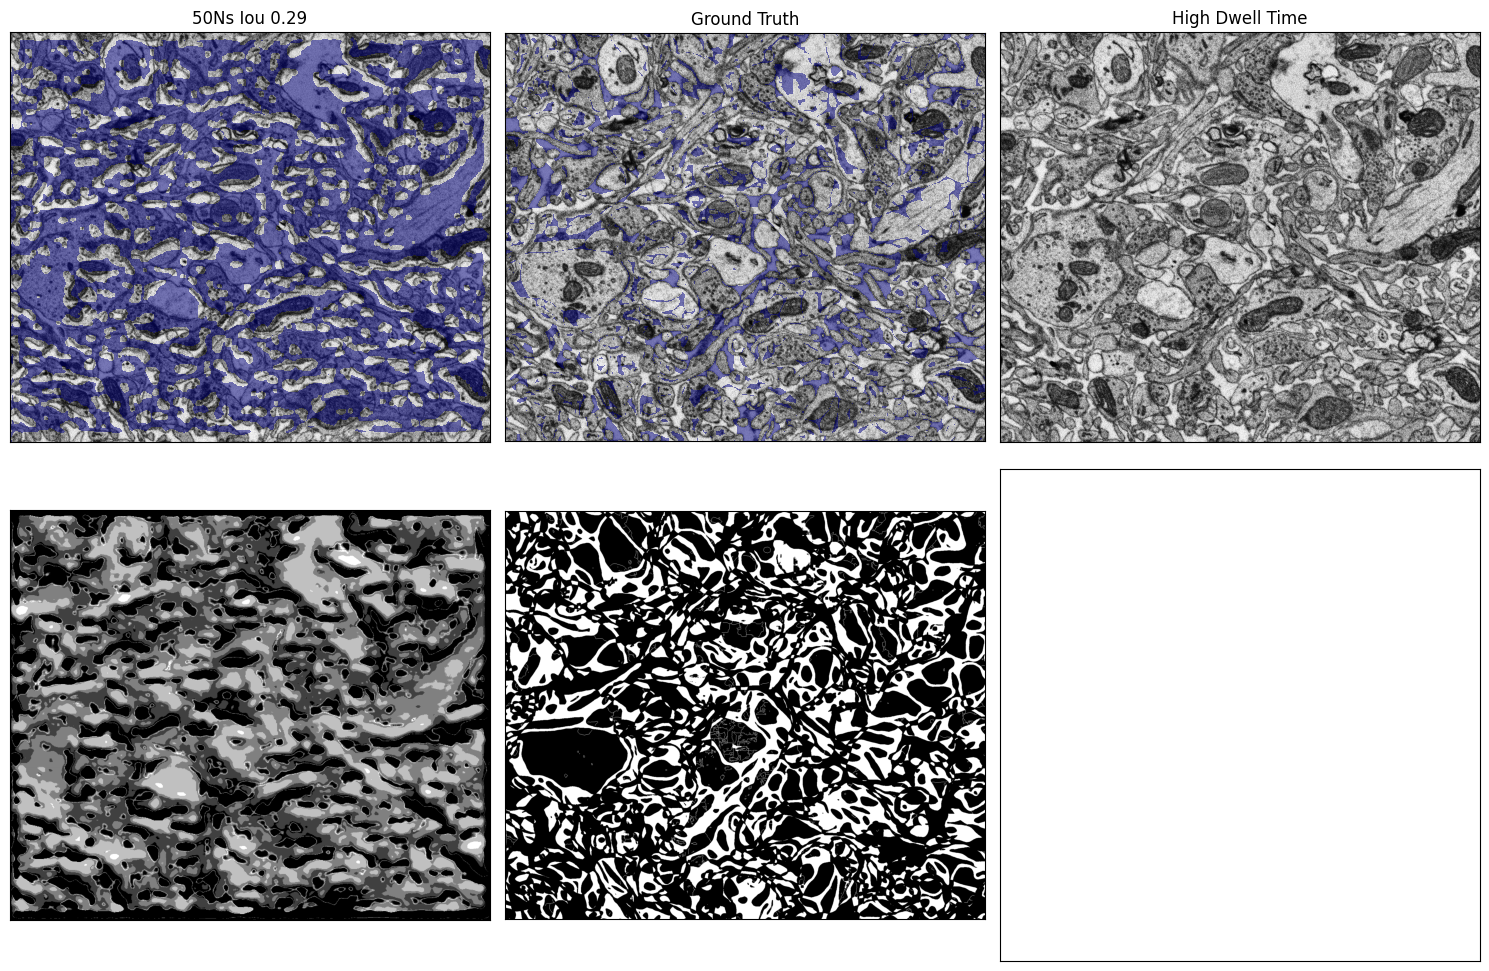

In [16]:
utils.visualize(**images)